# Exploratory Data Analysis

## Loading Packages

In [2]:
# Python Version
from platform import python_version
print('Python version: ', python_version())

Python version:  3.9.16


In [3]:
# Imports

## Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import missingno
%matplotlib inline
from pathlib import Path

# Statistics
from scipy import stats

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
# Package versions
%reload_ext watermark
%watermark -a "Cézar Mendes" --iversions

Author: Cézar Mendes

scipy     : 1.10.1
seaborn   : 0.12.2
matplotlib: 3.7.1
sys       : 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
missingno : 0.5.1
numpy     : 1.24.3
pandas    : 1.5.3



## Loading Data

In [5]:
df = pd.read_csv('../data/Prep_BankCustomerChurn.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


# EDA - Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  int64  
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 937.6+ KB


## Frequency Table

In [7]:
def frequency_table(dataframe, columns):
    freq_table = pd.DataFrame()
    
    for col in columns:
        # Calculate absolute frequency
        freq_abs = dataframe[col].value_counts()
        
        # Calculate relative frequency
        freq_rel = freq_abs / len(dataframe[col])
        
        # Calculate relative frequency percentage
        freq_rel_perc = freq_rel * 100
        
        # Create frequency table for the current column
        col_table = pd.concat([freq_abs, freq_rel, freq_rel_perc], axis=1)
        col_table.columns = ['Frequency Absolute', 'Frequency Relative', 'Frequency Relative (%)']
        
        # Add the current column's frequency table to the overall frequency table
        freq_table = pd.concat([freq_table, col_table])
        
    # Reset index to turn the unique values into a column
    freq_table.reset_index(inplace=True)
    
    # Rename the column holding the unique values
    freq_table.rename(columns={'index': 'Unique Values'}, inplace=True)
    
    # Add column labels to the frequency table
    freq_table['Column'] = [col for col in columns for _ in range(len(dataframe[col].value_counts()))]
    freq_table.set_index(['Column', 'Unique Values'], inplace=True)
    
    return freq_table


In [8]:
df_ = df.copy()

In [9]:

df_[['country', 'gender', 'churn', 'active_member', 'credit_card', 'products_number']] = df_[['country', 'gender', 'churn', 'active_member', 'credit_card', 'products_number']].astype('category')

frequency_table(df_,df_[['country', 'gender', 'churn', 'active_member', 'credit_card', 'products_number']] )

Frequency Absolute  Frequency Relative  \
Column          Unique Values                                           
country         France                       5014              0.5014   
                Germany                      2509              0.2509   
                Spain                        2477              0.2477   
gender          1                            5457              0.5457   
                0                            4543              0.4543   
churn           0                            7963              0.7963   
                1                            2037              0.2037   
active_member   1                            5151              0.5151   
                0                            4849              0.4849   
credit_card     1                            7055              0.7055   
                0                            2945              0.2945   
products_number 1                            5084              0.5084   
                2                            4590              0.4590   
                3                             266              0.0266   
                4                              60              0.0060   

                               Frequency Relative (%)  
Column          Unique Values                          
country         France                          50.14  
                Germany                         25.09  
                Spain                           24.77  
gender          1                               54.57  
                0                               45.43  
churn           0                               79.63  
                1                               20.37  
active_member   1                               51.51  
                0                               48.49  
credit_card     1                               70.55  
                0                               29.45  
products_number 1                               50.84  
                2                               45.90  
                3                                2.66  
                4                                0.60

## Descriptive Analysis

In [10]:
num_list = df.select_dtypes(['float64', 'int64']).drop(columns = ['customer_id','gender', 'churn', 'active_member', 'credit_card', 'products_number']).columns.tolist()
num_list

['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

In [13]:
# Describe
def count_outliers(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   out = ((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))).sum()
   return out

# Skew
def calc_skew(df):
    return [df[col].skew() for col in df]


# Summary Table
def getOverview(df):
    min = df.min()
    Q1 = df.quantile(0.25)
    mean = np.mean(df)
    median = df.quantile(0.5)
    Q3 = df.quantile(0.75)
    max = df.max()
    IQR = Q3 - Q1
    skew = calc_skew(df)
    outliers = count_outliers(df)
    cut_off = IQR * 1.5
    lower, upper = Q1 - cut_off, Q3 + cut_off
        
    

    new_columns = ['Columns name', 'Min', 'Q1','Mean', 'Median', 'Q3', 'Max', 'IQR', 'Lower fence', 'Upper fence', 'Skew', 'Num_Outliers']
        
    data = zip([column for column in df], min, Q1, mean,  median, Q3, max, IQR, lower, upper, skew, outliers)

    new_df = pd.DataFrame(data = data, columns = new_columns)
        
    new_df.set_index('Columns name', inplace = True)
    \
    return new_df.sort_values('Num_Outliers', ascending = False).transpose()

getOverview(df[num_list]).round(2)

Columns name,age,credit_score,tenure,balance,estimated_salary
Min,18.00,350.00,0.00,0.00,11.58
Q1,32.00,584.00,3.00,0.00,51002.11
Mean,38.92,650.53,5.01,76485.89,100090.24
Median,37.00,652.00,5.00,97198.54,100193.92
Q3,44.00,718.00,7.00,127644.24,149388.25
Max,92.00,850.00,10.00,250898.09,199992.48
IQR,12.00,134.00,4.00,127644.24,98386.14
Lower fence,14.00,383.00,-3.00,-191466.36,-96577.10
Upper fence,62.00,919.00,13.00,319110.60,296967.45
Skew,1.01,-0.07,0.01,-0.14,0.00


### Age

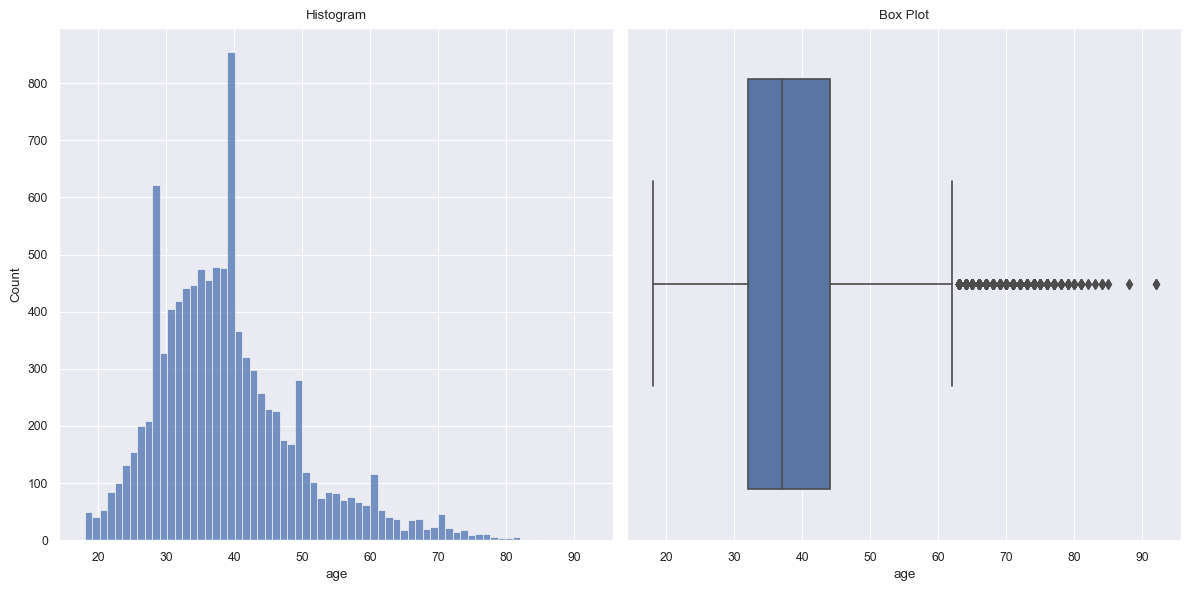

In [25]:
# Plot - Age
sns.set_theme(style="darkgrid")
sns.set_context('paper')

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram 
sns.histplot(data=df, x='age', ax=ax1)
ax1.set_title('Histogram')

# Plot box plot 
sns.boxplot(data=df, x='age', ax=ax2)
ax2.set_title('Box Plot')

# Adjust spacing between subplots
plt.tight_layout()


plt.show()

### Credit Score

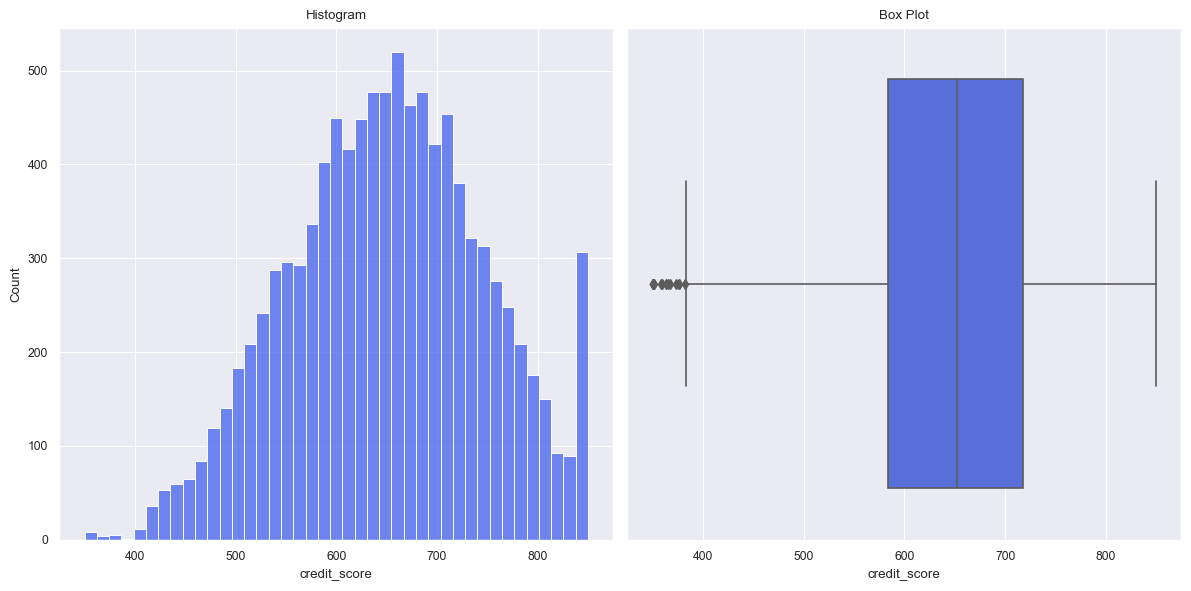

In [33]:
# Plot - Credit Score
sns.set_theme(style="darkgrid")
sns.set_context('paper')


# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram 
sns.histplot(data=df, x='credit_score', ax=ax1, color = "#4361EE")
ax1.set_title('Histogram')

# Plot box plot 
sns.boxplot(data=df, x='credit_score', ax=ax2, color = "#4361EE")
ax2.set_title('Box Plot')

# Adjust spacing between subplots
plt.tight_layout()


plt.show()

### Tenure

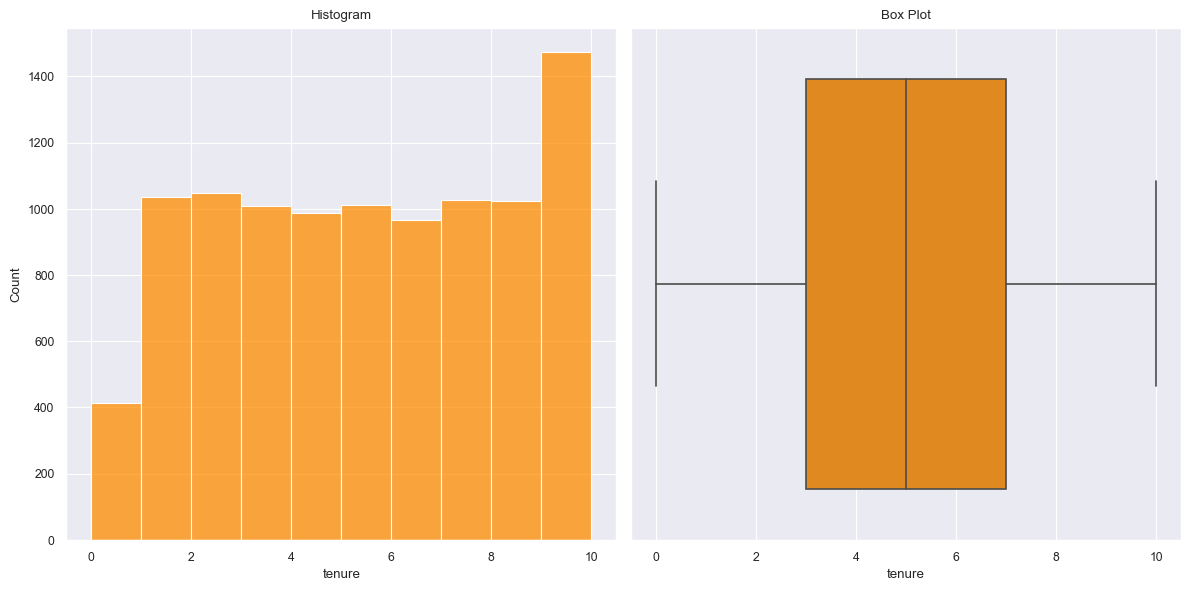

In [38]:
# Plot - Tenure
sns.set_theme(style="darkgrid")
sns.set_context('paper')


# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram 
sns.histplot(data=df, x='tenure', ax=ax1, color = "darkorange", bins = 10)
ax1.set_title('Histogram')

# Plot box plot 
sns.boxplot(data=df, x='tenure', ax=ax2, color = "darkorange")
ax2.set_title('Box Plot')

# Adjust spacing between subplots
plt.tight_layout()


plt.show()

### Balance

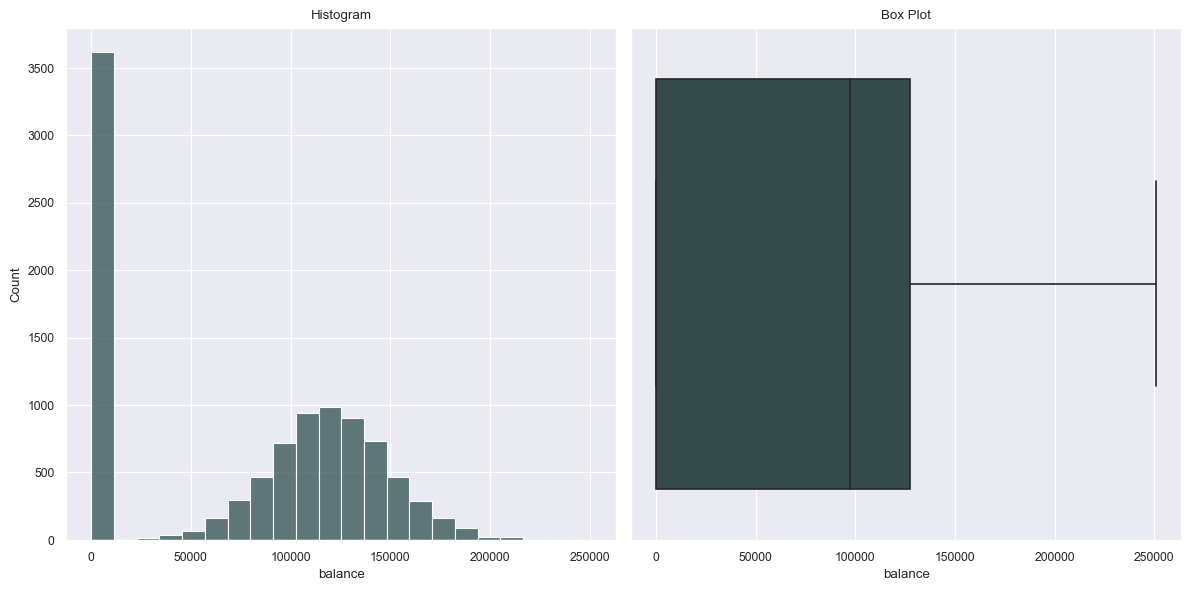

In [40]:
# Plot - Balance
sns.set_theme(style="darkgrid")
sns.set_context('paper')


# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram 
sns.histplot(data=df, x='balance', ax=ax1, color = "darkslategrey")
ax1.set_title('Histogram')

# Plot box plot 
sns.boxplot(data=df, x='balance', ax=ax2, color = "darkslategrey")
ax2.set_title('Box Plot')

# Adjust spacing between subplots
plt.tight_layout()


plt.show()

### Estimated Salary

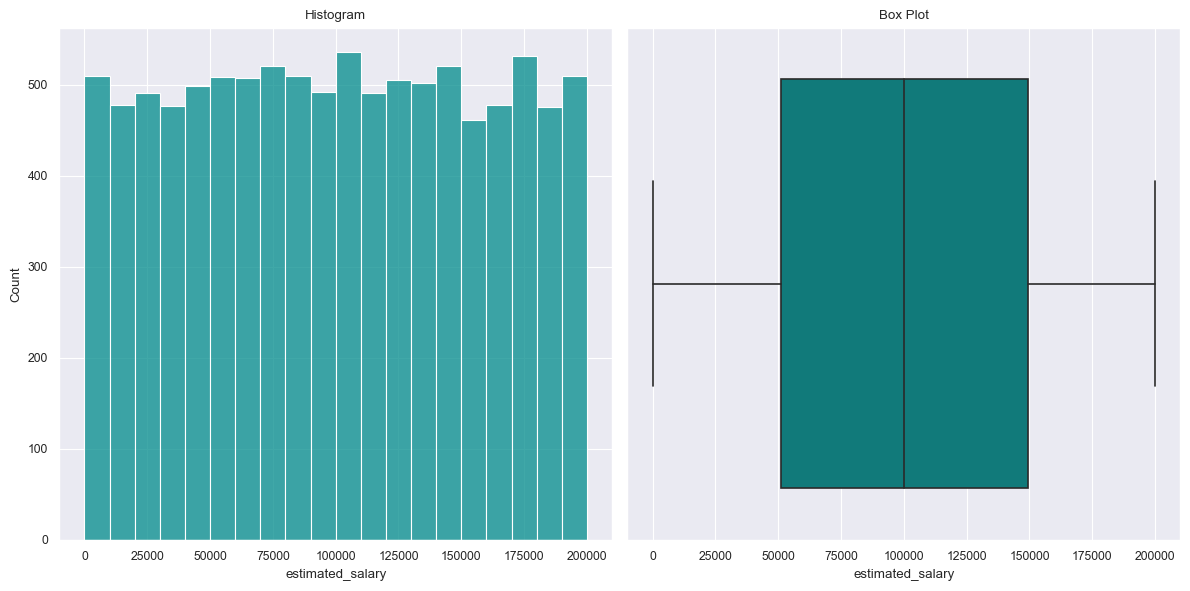

In [51]:
# Plot - estimated_salary
sns.set_theme(style="darkgrid")
sns.set_context('paper')


# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram 
sns.histplot(data=df, x='estimated_salary', ax=ax1, color = "darkcyan", bins = 20)
ax1.set_title('Histogram')

# Plot box plot 
sns.boxplot(data=df, x='estimated_salary', ax=ax2, color = "darkcyan")
ax2.set_title('Box Plot')

# Adjust spacing between subplots
plt.tight_layout()


plt.show()